In [2]:
%matplotlib inline

import collections
from functools import partial
import math
import matplotlib.pyplot as plt
import os
import random
import time
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange

import tensorflow as tf

# Helper TensorFlow functions
from utils import maybe_download

# The encoder-decoder architecture
from nmt.model import AttentionalModel, LSTMCell
from nmt.utils import vocab_utils
from nmt.train import train

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
from nmt import inference
from nmt.utils import misc_utils as utils

In [4]:
from nmt.train import run_sample_decode

In [5]:
def create_standard_hparams(data_path, out_dir):
    
    hparams = tf.contrib.training.HParams(
        
        # Data
        src="vi",
        tgt="en",
        train_prefix=os.path.join(data_path, "train"),
        dev_prefix=os.path.join(data_path, "tst2012"),
        test_prefix=os.path.join(data_path, "tst2013"),
        vocab_prefix="",
        embed_prefix="",
        out_dir=out_dir,
        src_vocab_file=os.path.join(data_path, "vocab.vi"),
        tgt_vocab_file=os.path.join(data_path, "vocab.en"),
        src_embed_file="",
        tgt_embed_file="",
        src_file=os.path.join(data_path, "train.vi"),
        tgt_file=os.path.join(data_path, "train.en"),
        dev_src_file=os.path.join(data_path, "tst2012.vi"),
        dev_tgt_file=os.path.join(data_path, "tst2012.en"),
        test_src_file=os.path.join(data_path, "tst2013.vi"),
        test_tgt_file=os.path.join(data_path, "tst2013.en"),

        # Networks
        num_units=512,
        num_layers=1,
        num_encoder_layers=1,
        num_decoder_layers=1,
        num_encoder_residual_layers=0,
        num_decoder_residual_layers=0,
        dropout=0.2,
        unit_type="lstm",
        encoder_type="uni",
        residual=False,
        time_major=True,
        num_embeddings_partitions=0,

        # Train
        optimizer="adam",
        batch_size=128,
        init_op="uniform",
        init_weight=0.1,
        max_gradient_norm=100.0,
        learning_rate=0.001,
        warmup_steps=0,
        warmup_scheme="t2t",
        decay_scheme="luong234",
        colocate_gradients_with_ops=True,
        num_train_steps=12000,

        # Data constraints
        num_buckets=5,
        max_train=0,
        src_max_len=25,
        tgt_max_len=25,
        src_max_len_infer=0,
        tgt_max_len_infer=0,

        # Data format
        sos="<s>",
        eos="</s>",
        subword_option="",
        check_special_token=True,

        # Misc
        forget_bias=1.0,
        num_gpus=1,
        epoch_step=0,  # record where we were within an epoch.
        steps_per_stats=100,
        steps_per_external_eval=0,
        share_vocab=False,
        metrics=["bleu"],
        log_device_placement=False,
        random_seed=None,
        # only enable beam search during inference when beam_width > 0.
        beam_width=0,
        length_penalty_weight=0.0,
        override_loaded_hparams=True,
        num_keep_ckpts=5,
        avg_ckpts=False,
        num_intra_threads=0,
        num_inter_threads=0,

        # For inference
        inference_indices=None,
        infer_batch_size=32,
        sampling_temperature=0.0,
        num_translations_per_input=1,
        
    )
    
    src_vocab_size, _ = vocab_utils.check_vocab(hparams.src_vocab_file, hparams.out_dir)
    tgt_vocab_size, _ = vocab_utils.check_vocab(hparams.tgt_vocab_file, hparams.out_dir)
    hparams.add_hparam('src_vocab_size', src_vocab_size)
    hparams.add_hparam('tgt_vocab_size', tgt_vocab_size)
    
    out_dir = hparams.out_dir
    if not tf.gfile.Exists(out_dir):
        tf.gfile.MakeDirs(out_dir)
         
    for metric in hparams.metrics:
        hparams.add_hparam("best_" + metric, 0)  # larger is better
        best_metric_dir = os.path.join(hparams.out_dir, "best_" + metric)
        hparams.add_hparam("best_" + metric + "_dir", best_metric_dir)
        tf.gfile.MakeDirs(best_metric_dir)

        if hparams.avg_ckpts:
            hparams.add_hparam("avg_best_" + metric, 0)  # larger is better
            best_metric_dir = os.path.join(hparams.out_dir, "avg_best_" + metric)
            hparams.add_hparam("avg_best_" + metric + "_dir", best_metric_dir)
            tf.gfile.MakeDirs(best_metric_dir)

    return hparams

In [6]:
class LSTMCellWithAttention(LSTMCell):
    
    def __init__(self, num_units, memory):
        super(LSTMCellWithAttention, self).__init__(num_units)
        self.memory = memory
        
    def attention(self):
        raise NotImplementedError("The subclass must implement this method!")

    def call(self, inputs, state):
        """Run this LSTM cell with attention on inputs, conditional on state."""
        
        # Cell and hidden states of the LSTM
        c, h = state
        
        # Source (encoder) states to attend over
        source_states = self.memory
        
        # Cell activation (e.g., tanh, relu, etc.)
        activation = self._activation
        
        # LSTM cell parameters
        kernel = self._kernel
        bias = self._bias
        forget_bias = self._forget_bias
        
        ### YOUR CODE HERE
        # shapes of tensors
        # input [batch, state_size] or [batch, num_units] 
        # source_states [batch, input_length, state_size]
        # c [batch, state_size]
        # h [batch, state_size]
        
        lstm_matrix = tf.matmul(tf.concat([inputs, h], 1), kernel) # [batch, 4*state_size]
        lstm_matrix = tf.add(lstm_matrix, bias)
        i, g, f, o = tf.split(lstm_matrix, 4, 1) # each size [batch, state_size]
        new_c = tf.sigmoid(f + forget_bias) * c + tf.sigmoid(i) * activation(g)
        new_h = tf.sigmoid(o) * activation(new_c)
        
        attention_vector = self.attention(new_h, source_states) # what's target_state here?      
        ### END YOUR CODE
        ### Your code should compute attention vector, new_c and new_h

        # Adhering to convention
        new_state = tf.contrib.rnn.LSTMStateTuple(new_c, new_h)
    
        return attention_vector, new_state 


class LSTMCellWithDotProductAttention(LSTMCellWithAttention):
        
    def build(self, inputs_shape):
        super(LSTMCellWithDotProductAttention, self).build(inputs_shape)
        self._W_c = self.add_variable("W_c", 
                                      shape=[self._num_units + self._num_units, 
                                             256])

    def attention(self, target_state, source_states):
        """Return the attention vector computed from attending over
        source_states using a function of target_state and source_states."""
        
        ### YOUR CODE HERE
        #raise NotImplementedError("Need to implement dot-product attention.")
        
        # shapes of tensors
        # source_states [batch, input_length, state_size]
        # target_state [batch, state_size]

        scores = tf.matmul(source_states, tf.expand_dims(target_state, -1)) # [batch, input_length, 1]
        scores = scores - tf.reduce_max(scores, 1, keepdims=True)
        scores_exp = tf.exp(scores)
        scores = scores_exp/tf.reduce_sum(scores_exp, 1, keepdims=True)
        
        c = tf.squeeze(tf.matmul(source_states, tf.Print(scores, [scores],summarize = 30), transpose_a=True), -1) # [batch, state_size]
        
        ### END YOUR CODE
        
        ### Your code should compute the context vector c
        attention_vector = tf.tanh(tf.matmul(tf.concat([c, target_state], -1), self._W_c))
        
        return attention_vector

In [7]:
hparams = create_standard_hparams(data_path=os.path.join("datasets", "nmt_data_vi"), 
                                  out_dir="nmt_model_dotprodatt")
hparams.add_hparam("attention_cell_class", LSTMCellWithDotProductAttention)

# Vocab file datasets/nmt_data_vi/vocab.vi exists
# Vocab file datasets/nmt_data_vi/vocab.en exists


In [8]:
log_device_placement = hparams.log_device_placement
out_dir = hparams.out_dir
scope = None
target_session=""

In [9]:
from nmt import model_helper

In [10]:
model_creator = AttentionalModel
infer_model = model_helper.create_infer_model(model_creator, hparams, scope)

# creating infer graph ...
  num_layers = 1, num_residual_layers=0
  cell 0  LSTM, forget_bias=1  DeviceWrapper, device=/gpu:0
  cell 0  LSTMCellWithDotProductAttention, dropout=0   LSTMCellWithDotProductAttention  DeviceWrapper, device=/gpu:0
# Trainable variables
  embeddings/encoder/embedding_encoder:0, (7709, 512), /device:GPU:0
  embeddings/decoder/embedding_decoder:0, (17191, 512), /device:GPU:0
  dynamic_seq2seq/encoder/rnn/basic_lstm_cell/kernel:0, (1024, 2048), /device:GPU:0
  dynamic_seq2seq/encoder/rnn/basic_lstm_cell/bias:0, (2048,), /device:GPU:0
  dynamic_seq2seq/decoder/lstm_cell_with_dot_product_attention/kernel:0, (1024, 2048), /device:GPU:0
  dynamic_seq2seq/decoder/lstm_cell_with_dot_product_attention/bias:0, (2048,), /device:GPU:0
  dynamic_seq2seq/decoder/lstm_cell_with_dot_product_attention/W_c:0, (1024, 256), /device:GPU:0
  dynamic_seq2seq/decoder/output_projection/kernel:0, (256, 17191), 


In [11]:
# Preload data for sample decoding.
dev_src_file = "%s.%s" % (hparams.dev_prefix, hparams.src)
dev_tgt_file = "%s.%s" % (hparams.dev_prefix, hparams.tgt)
sample_src_data = inference.load_data(dev_src_file)
sample_tgt_data = inference.load_data(dev_tgt_file)

model_dir = hparams.out_dir

In [12]:
# TensorFlow model
config_proto = utils.get_config_proto(
  log_device_placement=log_device_placement,
  num_intra_threads=hparams.num_intra_threads,
  num_inter_threads=hparams.num_inter_threads)
infer_sess = tf.Session(
  target=target_session, config=config_proto, graph=infer_model.graph)

In [61]:
run_sample_decode(infer_model, infer_sess,
                        model_dir, hparams, sample_src_data,
                        sample_tgt_data)

INFO:tensorflow:Restoring parameters from nmt_model_dotprodatt/translate.ckpt-12000
  loaded infer model parameters from nmt_model_dotprodatt/translate.ckpt-12000, time 0.08s
  # 927
    src: Hiện tại tôi làm việc trong ngành công nghiệp năng lượng mặt trời .
    ref: Now I work in the solar technology industry .
    nmt: Now I work in solar industry .


In [ ]:
[[[0.0840193406][0.190338716][0.533165097][0.0874509][0.0676413][0.00807091594][0.00161030609][0.00111503887][0.000931647199][0.000566977251][0.000944232394][0.00140267133][0.0124362875][0.0103065902]]
[[0.00804786198][0.0217310451][0.874472857][0.0236717518][0.0456302576][0.00722790556][0.00247577112][0.00198398018][0.000963972][0.000875130645][0.00166767661][0.00125604554][0.00881466735][0.00118113111]]
[[0.0121418471][0.0103726387][0.0181948971][0.226083338][0.648831487][0.0393517949][0.0309775677][0.00487296749][0.00200056564][0.00178571814][0.00226611877][0.00127268699][0.000835115789][0.00101323705]]
[[0.00834437367][0.0237123203][0.0147254951][0.021609677][0.152907819][0.62871021][0.0542027764][0.00867951382][0.00661987392][0.0193492714][0.0159173179][0.0217176881][0.0208468735][0.00265678624]]
[[0.00148338405][0.000618223392][0.000273195357][0.0006839782][0.00215626601][0.00160297472][0.00181700068][0.0226691216][0.037184272][0.048885148][0.425939441][0.360947341][0.0951956][0.000544058392]]
[[0.00199879124][0.00219343347][0.00044669339][0.000468273531][0.00332005][0.000940420199][0.0640797392][0.136126772][0.598374367][0.0520433933][0.124235965][0.0094546238][0.00445094053][0.0018664581]]
[[0.0172098447][0.166985616][0.0141933896][0.0179880895][0.0659823939][0.0175693743][0.020267155][0.00189624855][0.016407337][0.00604771962][0.0164372623][0.139828131][0.0509688072][0.448218584]]
[[0.0820801705][0.18350789][0.484996617][0.00938066654][0.0641990155][0.0260316692][0.00948721357][0.00421708217][0.00490227761][0.00256767194][0.0026750972][0.00860086177][0.0361012891][0.0812525153]]]

Use scores_parser script to parse the scores

In [25]:
scores = np.array([[0.0840193406,0.190338716,0.533165097,0.0874509,0.0676413,0.00807091594,0.00161030609,0.00111503887,0.000931647199,0.000566977251,0.000944232394,0.00140267133,0.0124362875,0.0103065902],
[0.00804786198,0.0217310451,0.874472857,0.0236717518,0.0456302576,0.00722790556,0.00247577112,0.00198398018,0.000963972,0.000875130645,0.00166767661,0.00125604554,0.00881466735,0.00118113111],
[0.0121418471,0.0103726387,0.0181948971,0.226083338,0.648831487,0.0393517949,0.0309775677,0.00487296749,0.00200056564,0.00178571814,0.00226611877,0.00127268699,0.000835115789,0.00101323705],
[0.00834437367,0.0237123203,0.0147254951,0.021609677,0.152907819,0.62871021,0.0542027764,0.00867951382,0.00661987392,0.0193492714,0.0159173179,0.0217176881,0.0208468735,0.00265678624],
[0.00148338405,0.000618223392,0.000273195357,0.0006839782,0.00215626601,0.00160297472,0.00181700068,0.0226691216,0.037184272,0.048885148,0.425939441,0.360947341,0.0951956,0.000544058392],
[0.00199879124,0.00219343347,0.00044669339,0.000468273531,0.00332005,0.000940420199,0.0640797392,0.136126772,0.598374367,0.0520433933,0.124235965,0.0094546238,0.00445094053,0.0018664581],
[0.0172098447,0.166985616,0.0141933896,0.0179880895,0.0659823939,0.0175693743,0.020267155,0.00189624855,0.016407337,0.00604771962,0.0164372623,0.139828131,0.0509688072,0.448218584],
[0.0820801705,0.18350789,0.484996617,0.00938066654,0.0641990155,0.0260316692,0.00948721357,0.00421708217,0.00490227761,0.00256767194,0.0026750972,0.00860086177,0.0361012891,0.0812525153]])

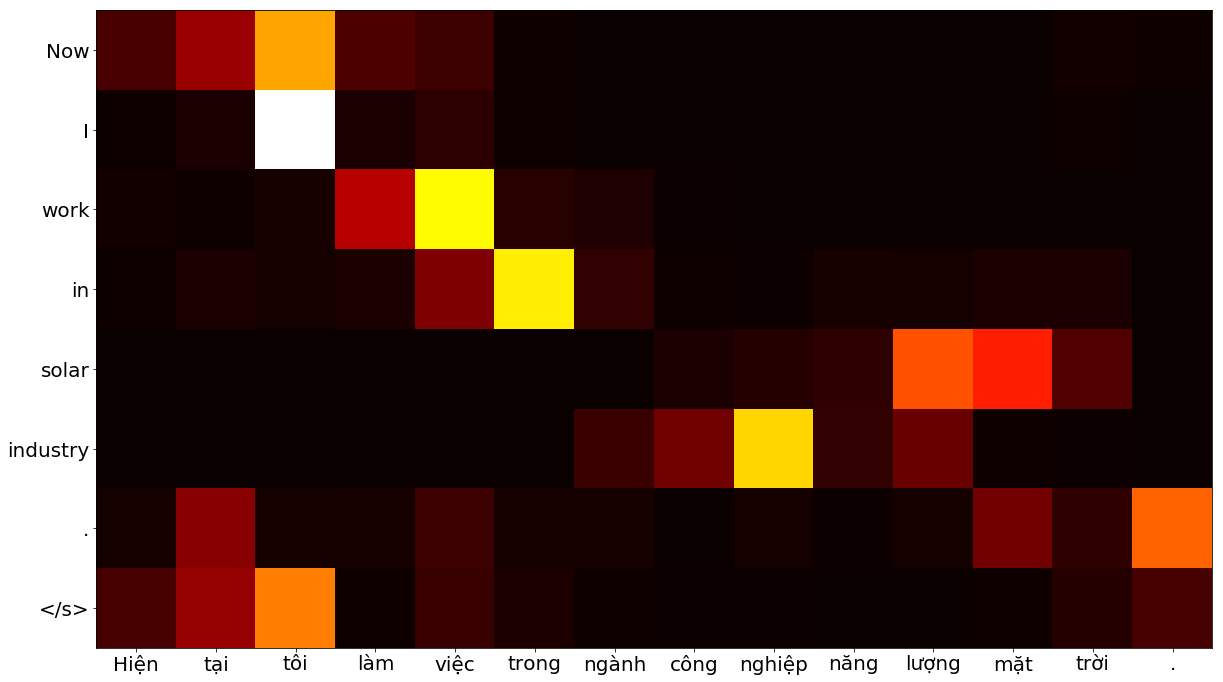

In [27]:
fig, ax1 = plt.subplots(1,1,figsize=(20, 20))
ax1.imshow(scores, cmap='hot')
ax1.set_yticklabels(["","Now","I","work","in","solar","industry",'.',"</s>"],fontsize=20)
ax1.set_xticks(np.arange(0, 14, 1))
ax1.set_xticklabels(["Hiện","tại","tôi","làm","việc","trong","ngành","công","nghiệp","năng","lượng","mặt","trời",'.'],fontsize=20)
plt.show()
fig.savefig("./heatmap/heatmap1.png")

In [112]:
run_sample_decode(infer_model, infer_sess,
                        model_dir, hparams, sample_src_data,
                        sample_tgt_data)

INFO:tensorflow:Restoring parameters from nmt_model_dotprodatt/translate.ckpt-12000
  loaded infer model parameters from nmt_model_dotprodatt/translate.ckpt-12000, time 0.08s
  # 608
    src: nhưng bạn biết điều gì không ?
    ref: But you know what ?
    nmt: But you know what ?


In [ ]:
[[[0.283267766][0.594901919][0.0403833464][0.00762861595][0.0245306864][0.0102527747][0.0390349366]]]
[[[0.0310722124][0.565596521][0.193239272][0.0346842334][0.124393061][0.021283811][0.0297308378]]]
[[[0.0692473128][0.0235723983][0.877542794][0.00330158486][0.010057901][0.0135178613][0.00276016]]]
[[[0.0276958216][0.0173921362][0.0177939888][0.10705968][0.754455686][0.0309311803][0.0446715057]]]
[[[0.038722042][0.0135365753][0.013384602][0.191705793][0.112811282][0.214509353][0.41533041]]]
[[[0.0449456125][0.590600193][0.0338435508][0.00850865711][0.0961521193][0.198730052][0.0272198617]]]

In [23]:
scores2 = np.array([[0.283267766,0.594901919,0.0403833464,0.00762861595,0.0245306864,0.0102527747,0.0390349366],
[0.0310722124,0.565596521,0.193239272,0.0346842334,0.124393061,0.021283811,0.0297308378],
[0.0692473128,0.0235723983,0.877542794,0.00330158486,0.010057901,0.0135178613,0.00276016],
[0.0276958216,0.0173921362,0.0177939888,0.10705968,0.754455686,0.0309311803,0.0446715057],
[0.038722042,0.0135365753,0.013384602,0.191705793,0.112811282,0.214509353,0.41533041],
[0.0449456125,0.590600193,0.0338435508,0.00850865711,0.0961521193,0.198730052,0.0272198617]])

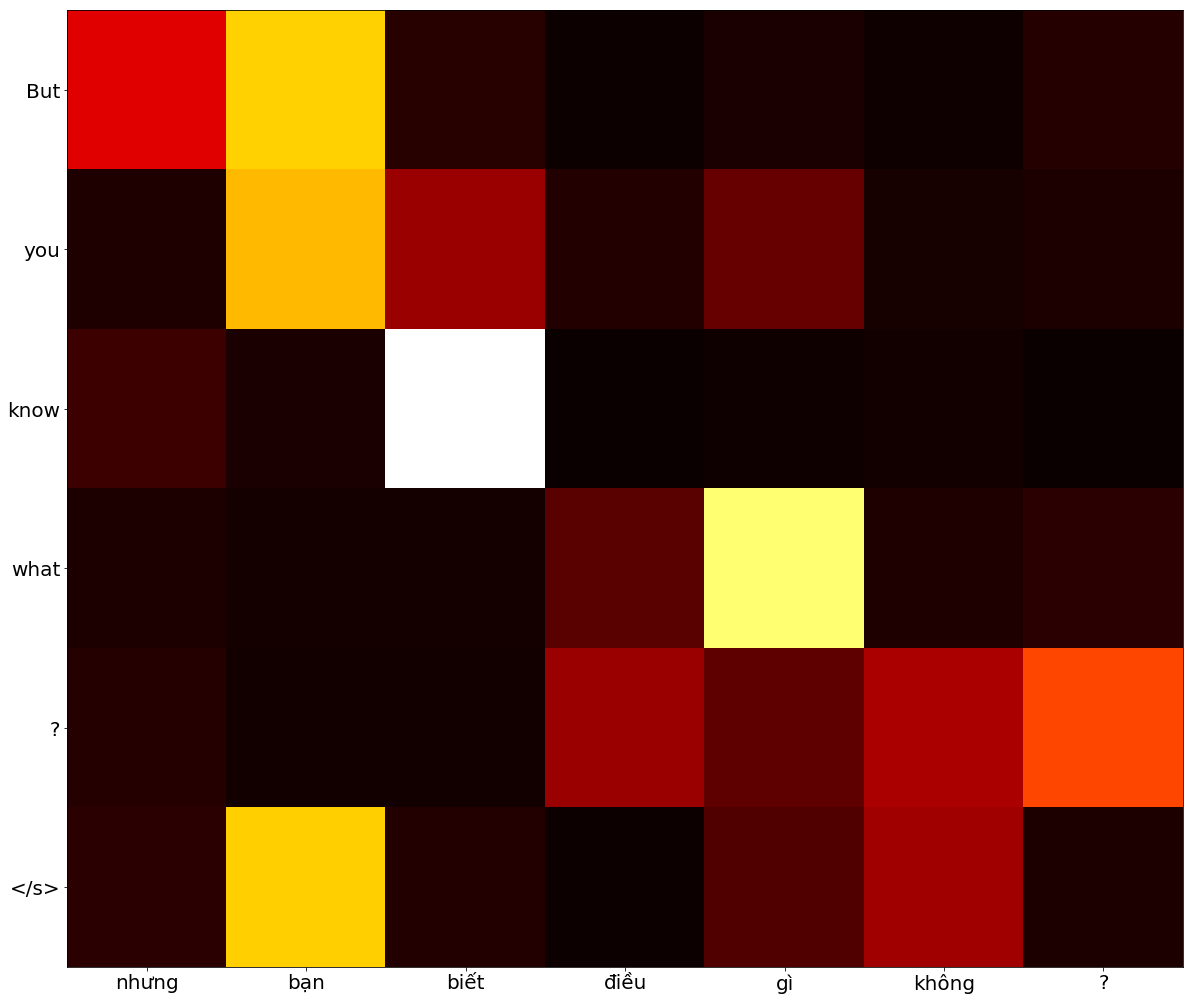

In [28]:
fig, ax1 = plt.subplots(1,1,figsize=(20, 20))
ax1.imshow(scores2, cmap='hot')
ax1.set_yticklabels(["","But","you","know","what","?","</s>"],fontsize=20)
ax1.set_xticks(np.arange(0, 7, 1))
ax1.set_xticklabels(["nhưng","bạn","biết","điều","gì","không","?"],fontsize=20)
plt.show()
fig.savefig("./heatmap/heatmap2.png")